# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Utility-Functions" data-toc-modified-id="Utility-Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Utility Functions</a></div><div class="lev1 toc-item"><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Logistic Regression</a></div><div class="lev2 toc-item"><a href="#Linearly-Separable-Data" data-toc-modified-id="Linearly-Separable-Data-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Linearly Separable Data</a></div><div class="lev2 toc-item"><a href="#Complex-Data---Moons" data-toc-modified-id="Complex-Data---Moons-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Complex Data - Moons</a></div><div class="lev2 toc-item"><a href="#Complex-Data---Circles" data-toc-modified-id="Complex-Data---Circles-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Complex Data - Circles</a></div><div class="lev1 toc-item"><a href="#Training-a-Deep-Neural-Network" data-toc-modified-id="Training-a-Deep-Neural-Network-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training a Deep Neural Network</a></div><div class="lev2 toc-item"><a href="#Complex-Data---Moons" data-toc-modified-id="Complex-Data---Moons-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Complex Data - Moons</a></div><div class="lev2 toc-item"><a href="#Complex-Data---Circles" data-toc-modified-id="Complex-Data---Circles-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Complex Data - Circles</a></div><div class="lev2 toc-item"><a href="#Complex-Data---Sine-Wave" data-toc-modified-id="Complex-Data---Sine-Wave-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Complex Data - Sine Wave</a></div><div class="lev1 toc-item"><a href="#Case-Study---Binary-Classification" data-toc-modified-id="Case-Study---Binary-Classification-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Case Study - Binary Classification</a></div><div class="lev2 toc-item"><a href="#Data-Visualization-&amp;-Preparation" data-toc-modified-id="Data-Visualization-&amp;-Preparation-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Data Visualization &amp; Preparation</a></div><div class="lev2 toc-item"><a href="#Logistic-Regression-Model" data-toc-modified-id="Logistic-Regression-Model-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Logistic Regression Model</a></div><div class="lev2 toc-item"><a href="#Deep-Model" data-toc-modified-id="Deep-Model-43"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Deep Model</a></div><div class="lev1 toc-item"><a href="#Case-Study---MultiClass-Classification" data-toc-modified-id="Case-Study---MultiClass-Classification-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Case Study - MultiClass Classification</a></div>

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

from __future__ import print_function
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier

# Utility Functions

These are the plotting helper functions used further down in the notebook. You don't need to fully understand what's going on here to get the big picture. The names of the functions are self-explanatory. I would at first recommend to skip this part and proceed to the next Logistic Regression section.

In [3]:
def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)


def plot_data(X, y):
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['acc'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def plot_confusion_matrix(model, X, y):
    y_pred = model.predict_classes(X, verbose=0)
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

def plot_compare_histories(history_list, name_list):
    dflist = []
    for history in history_list:
        dflist.append(pd.DataFrame(history.history, index=history.epoch))

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Loss")

    ax = plt.subplot(212)
    historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Accuracy")
    plt.xlabel("Epochs")

    plt.tight_layout()

# Logistic Regression

Despite its name, logistic regression (LR) is a binary *classification* algorithm. It's the most popular technique for 0/1 classification. LR will try to draw a straight line to separate the classes, that's where the term *linear model* comes from. LR works on arbitrary dimensions, not just two. For 3 dimensional data it'll try to draw a 2 dimensional plane to separate the classes. This generalizes to N dimensional data and N-1 dimensional hyperplane separator. If you have a supervised binary classification problem, given an input data with multiple columns and a binary 0/1 outcome, LR is the first method to try. In this section we will focus on 2 dimensional data since it's easier to visualize, and in the later sections we will work with multidimensional input.

## Linearly Separable Data

First let's start with the easy example. 2 dimensional linearly separable data. We are using the scikit-learn *make_classification* method to generate our data and use our helper function defined above to visualize it.

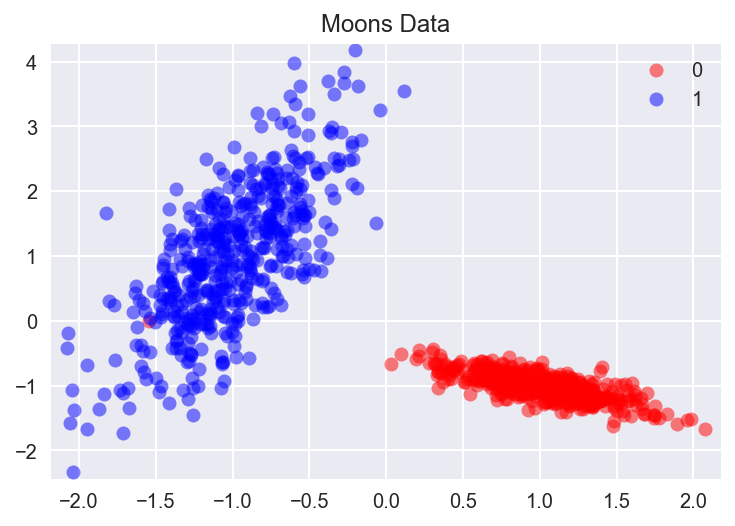

In [4]:
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, 
                           n_informative=2, random_state=7, n_clusters_per_class=1)
plot_data(X, y)
plt.title('Moons Data')

There is a *LogisticRegression* classifier available in scikit-learn, I won't go into too much detail here since our goal is to learn building models with Keras. But here's how to train an LR model, using the *fit* function just like any other model in scikit-learn. We see the linear decision boundary as the green line.

LR coefficients: [[-4.07231906  2.09044633]]
LR intercept: [-0.23103502]


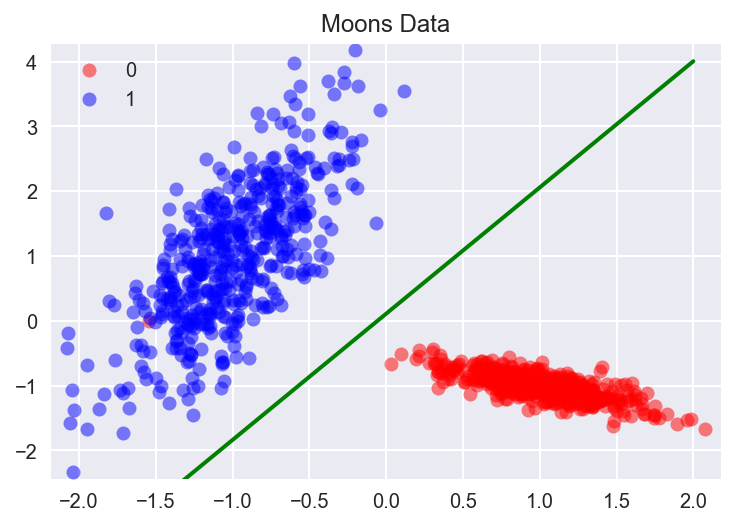

In [6]:
lr = LogisticRegression()
lr.fit(X, y)
print('LR coefficients:', lr.coef_)
print('LR intercept:', lr.intercept_)

plot_data(X, y)
plt.title('Moons Data')

limits = np.array([-2, 2])
boundary = -(lr.coef_[0][0] * limits + lr.intercept_[0]) / lr.coef_[0][1]
_ = plt.plot(limits, boundary, "g-", linewidth=2)

As we can see the data is linearly separable. We will train a logistic regression model with Keras to predict the class membership of every input point. To keep things simple for now, we won't perform the standard practices of separating out the data to training and test sets, or performing k-fold cross-validation. We will see examples of these in the later sections on real datasets. 

Keras has great documentation at https://keras.io/ so I won't go into every single detail, but will give a general overview.

We will use the *Sequential* model API available [here](https://keras.io/getting-started/sequential-model-guide/). The Sequential model allows us to build deep neural networks, by stacking layers one top of another. Since we're now building a simple logistic regression model, we will have the input nodes directly connected to output node, without any hidden layers.

Quick clarification to disambiguate the terms being used. In neural networks literature, it's common to talk about input nodes and output nodes. This may sound strange at first glance, what's an input *node* per se? When we say input nodes, we're talking about the features of a given data point. In our case we have 2 features, the x and y coordinates of the points we plotted above, so we have 2 input nodes. You can simply think of it as a vector of 2 numbers. What about the output node then? The output of the logistic regression model is a single number, the probability of an input data point belonging to class 1. In other words $P(class=1)$. The probability of an input point belonging to class 0 is then $P(class=0) = 1 - P(class=1)$. So you can simply think of the output node as a vector with a single number between 0 and 1.

In Keras we don't add layers corresponding to input nodes, we only do for hidden nodes and output nodes. In our current model, we don't have any hidden layers, the input nodes are directly connected to the output node. This means our neural network definition in Keras will just have one layer with one node, corresponding to the output node.

The *Dense* function in Keras constructs a fully connected neural network layer, automatically initializing the weights as biases. It's a super useful function that you will see everywhere. The function arguments are defined as follows:
- *units*: The first argument, the number of nodes in this layer. Since we're constructing the output layer, and we said it has only one node, this value is 1.
- *input_shape*: The first layer in Keras models need to specify the input dimensions. The subsequent layers (which we don't have here but we will in later sections) don't need to specify this argument because Keras can infer their dimensions automatically. In this our input dimensionality is 2, the x and y coordinates. The input_shape parameter expects a vector, so in our case it's simply a tuple with one number.
- *activation*: The activation function of a logistic regression model is the *logistic* function, or altenatively called as *sigmoid*. We will explore different activation functions and where to use them and why in another tutorial.

We then compile the Keras model with the *compile* function. This creates the neural network model by configuring the learning process. The model hasn't been trained yet. Right now we're specifying the optimizer to use and the loss function to minimize. The arguments for the compile function are defined as follows:
- *optimizer*: Which optimizer to use in order to minimize the loss function. There are a lot of different optimizers, most of them based on gradient descent. We will explore different optimizers in another tutorial. For now we will use the *adam* optimizer, which is the people prefer to use by default.
- *loss*: The loss function to minimize. Since we're building a binary 0/1 classifier, the loss function to minimize is *binary_crossentropy*. We will see other examples of loss functions in later sections.
- *metrics*: Which metric to report statistics on, for classification problems we set this as *accuracy*.

Now comes the fun part of actually training the model. The arguments are as follows:
- *x*: The input data, we defined it as *X* above. It contains the x and y coordinates of the input points
- *y*: Not to be confused with the y coordinate of the input points. In the tutorials you see online *y* refers the the labels, in our case the class we're trying to predict: 0 or 1.
- *verbose*: Prints out the loss and accuracy, set it to 1 to see the output.
- *epochs*: Number of times to over the training data. When training models we pass through the training data not just once but multiple times.

The output of the fit method is the loss and accuracy at every epoch. We then plot it to see that the loss goes down to almost 0 over time, and the accuracy goes up to almost 1. Great! We have successfully trained our first neural network model with Keras. I know this was a long explanation, but I wanted to explain what we're doing in detail the first time. Once you understand what's going on and practice a couple of times, all this becomes second nature.

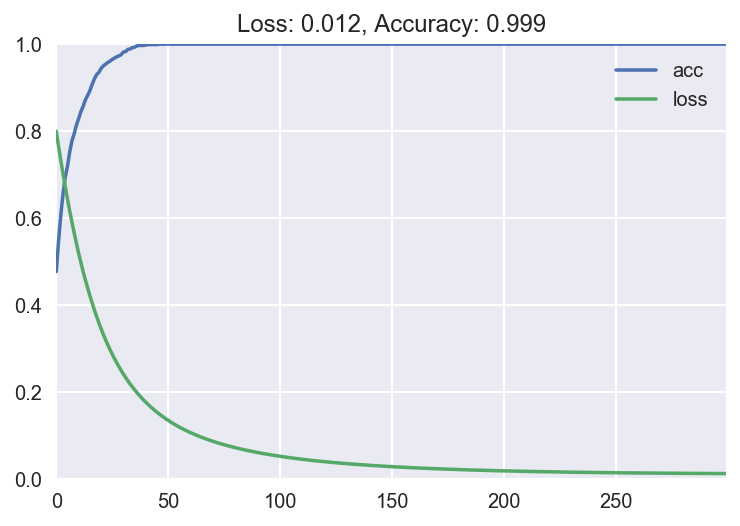

In [7]:
model = Sequential()
model.add(Dense(units=1, input_shape=(2,), activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x=X, y=y, verbose=0, epochs=300)
plot_loss_accuracy(history)

A fancy plot of the decision boundary. The various shades of blue and red represent the probability of a hypothetical point in that are belonging to class 1. The top left area is classified as class 1, so the dark blue. The bottom right area is classified as class 0, so the dark red. And there is a transition around the decision boundary. I think this is a cool way to visualize the separator function the model is learning.

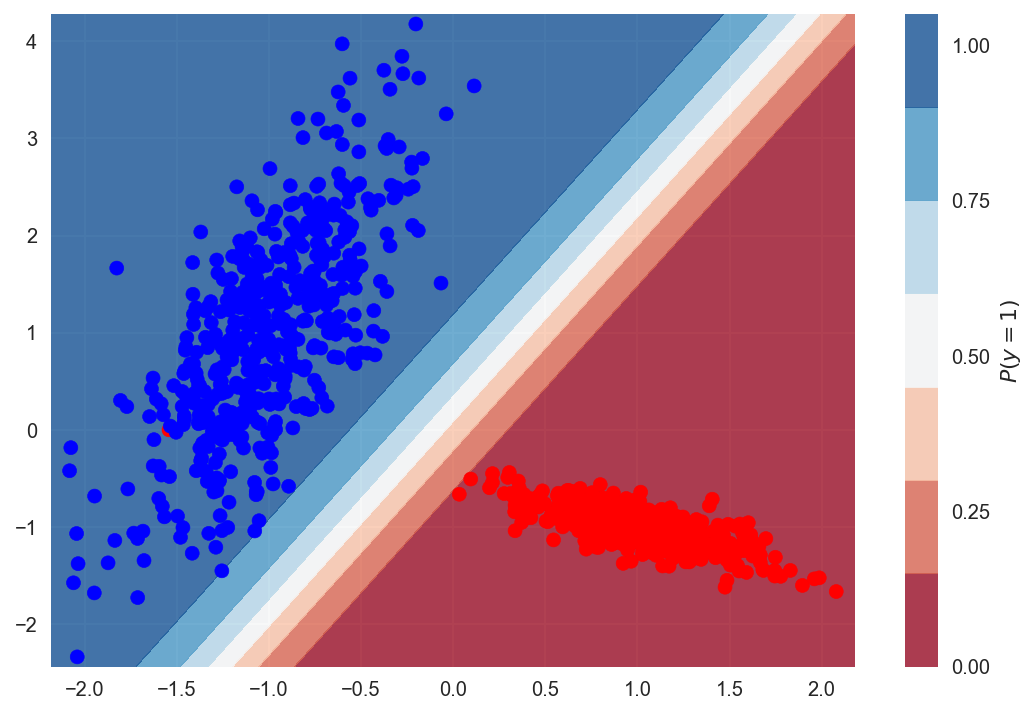

In [8]:
plot_decision_boundary(lambda x: model.predict(x), X, y)

The classification report showing the precision and recall of our model.

In [9]:
y_pred = model.predict_classes(X, verbose=0)
print(classification_report(y, y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       501
          1       1.00      1.00      1.00       499

avg / total       1.00      1.00      1.00      1000



The confusion matrix shows us how many classes were correctly classified vs misclassified. The numbers on the diagonal axis represent the number of correctly classified points, the rest are the misclassified ones. This particular matrix is not very interesting because the model correctly predicts the class of all but one point. We can see the misclassified point at the top right, true value is class 0 but the predicted value is class 1.

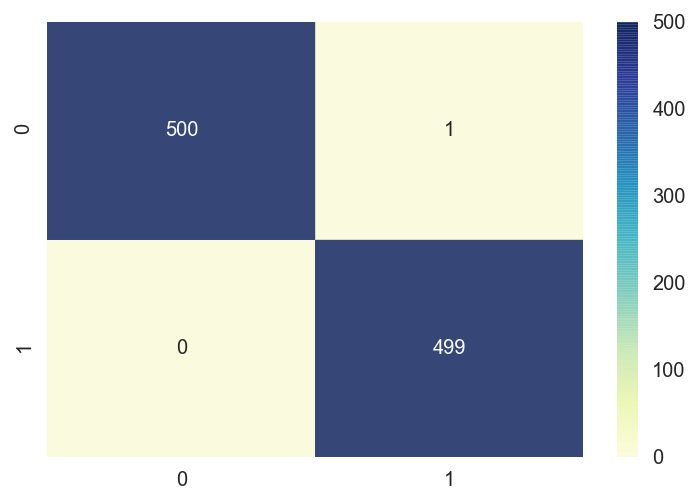

In [10]:
plot_confusion_matrix(model, X, y)

## Complex Data - Moons

The previous dataset was linearly separable, so it was trivial for our logistic regression model to separate the classes. Here is a more complex dataset which isn't linearly separable. The simple logistic regression model won't be able to distinguish between the classes.

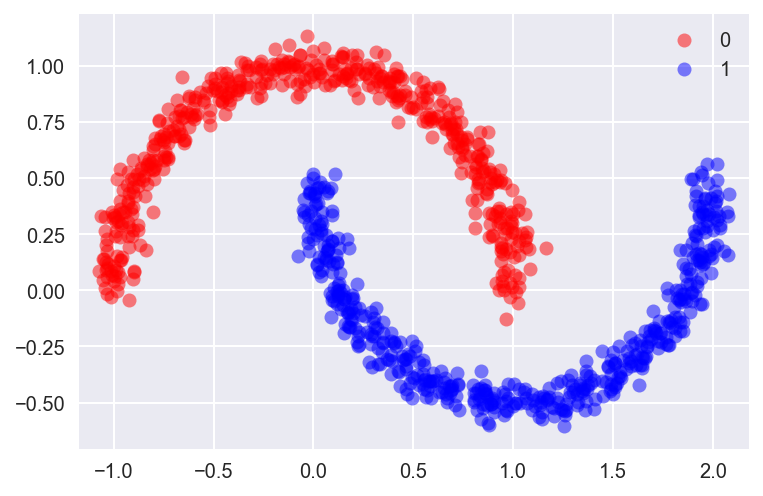

In [11]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=0)
plot_data(X, y)

We're building the another logistic regression model with the same parameters as we did before.

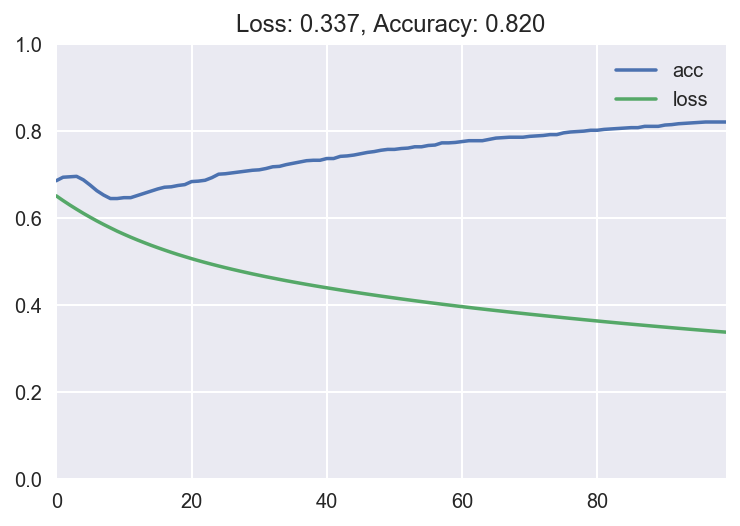

In [12]:
model = Sequential()
model.add(Dense(1, input_shape=(2,), activation='sigmoid'))

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=100)
plot_loss_accuracy(history)

The current decision boundary doesn't look as clean as the one before. The model tried to separate out the classes from the middle, but there are a lot of misclassified points. We need a more complex classifier with a non-linear decision boundary, and we will see an example of that soon.

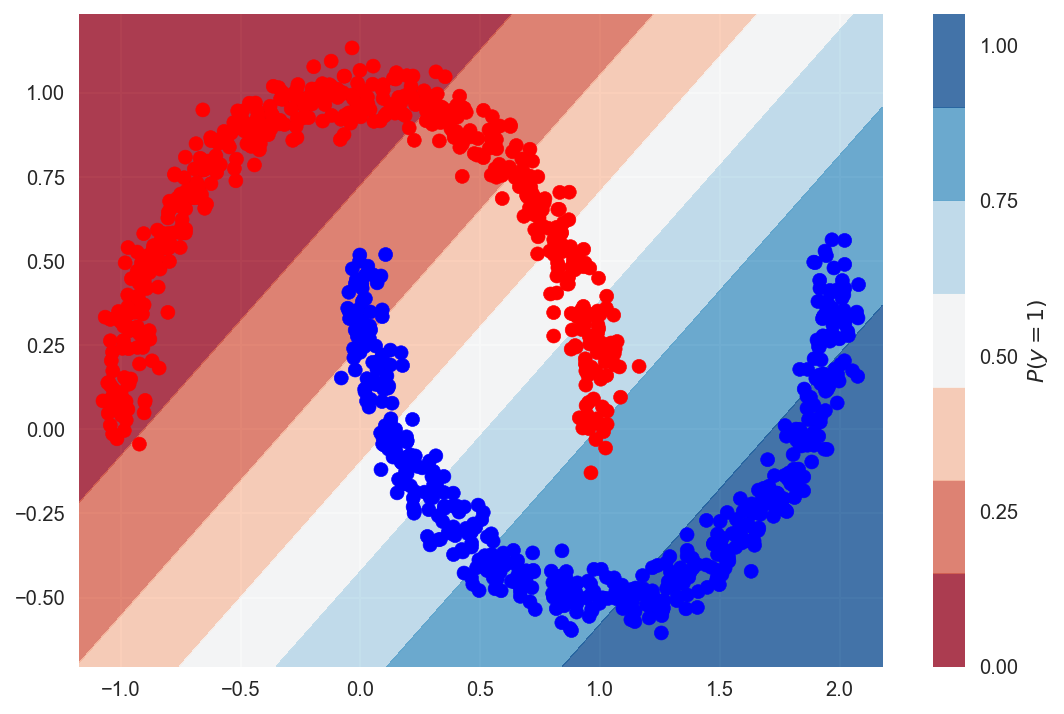

In [13]:
plot_decision_boundary(lambda x: model.predict(x), X, y)

Precision of the model is 86%. It looks good on paper but we should be able to get 100% with a more complex model. You can imagine a curved decision boundary that will separate out the classes, and a complex model should be able to approximate that.

             precision    recall  f1-score   support

          0       0.81      0.83      0.82       500
          1       0.83      0.81      0.82       500

avg / total       0.82      0.82      0.82      1000



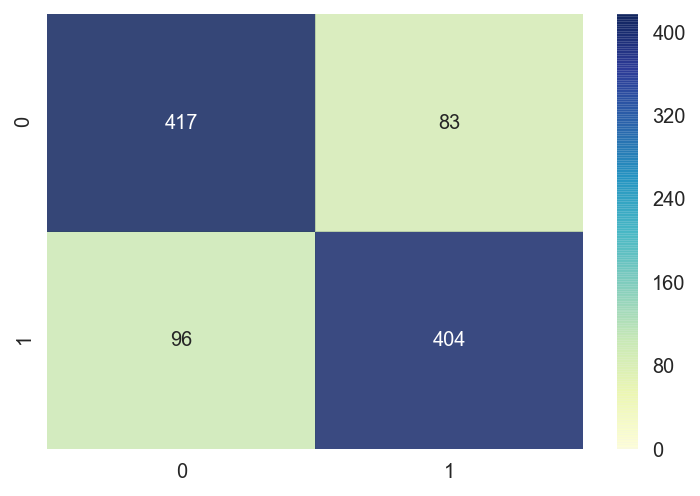

In [14]:
y_pred = model.predict_classes(X, verbose=0)
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)

## Complex Data - Circles

Let's look at one final example where the liner model will fail.

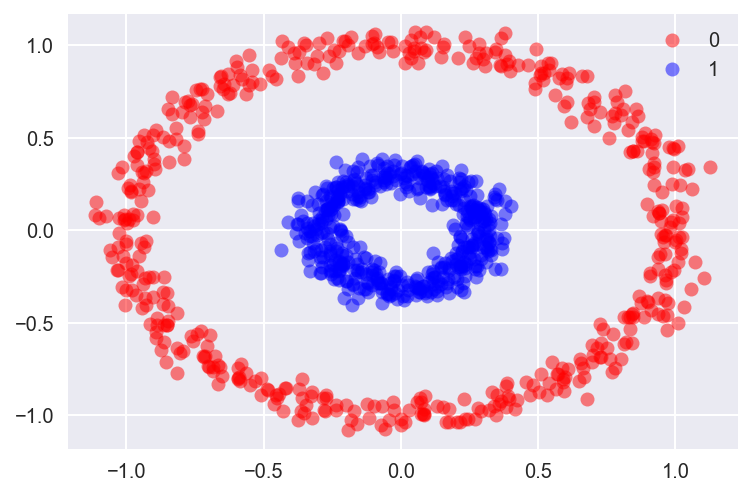

In [15]:
X, y = make_circles(n_samples=1000, noise=0.05, factor=0.3, random_state=0)
plot_data(X, y)

Building the model with same parameters.

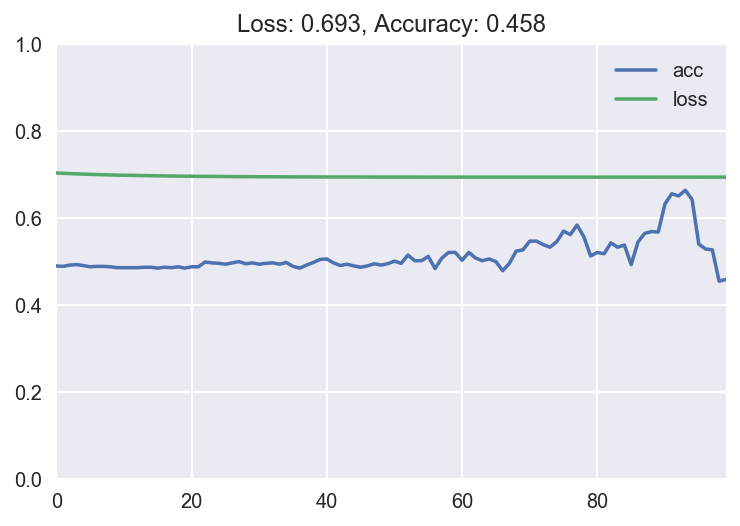

In [16]:
model = Sequential()
model.add(Dense(1, input_shape=(2,), activation='sigmoid'))

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=100)
plot_loss_accuracy(history)

The decision boundary again passes from the middle of the data, but now we have much more misclassified points.

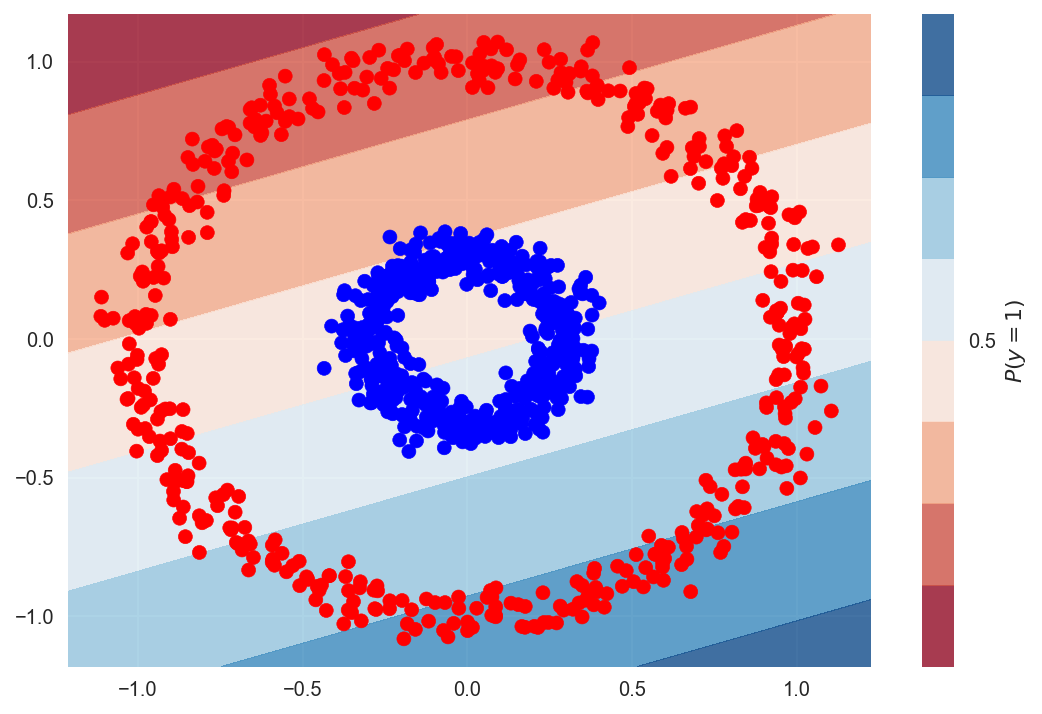

In [17]:
plot_decision_boundary(lambda x: model.predict(x), X, y)

The accuracy is 51%. No matter where the model draws the linear line, it will misclassify half of the points, due to the nature of the dataset.

The confusion matrix we see here is an example one belonging to a poor classifier. Ideally we want confusion matrices like the ones we saw above. High numbers along the diagonals meaning that the classifier was right, and low numbers everywhere else where the classifier was wrong. In our visualization, the color blue represents the high numbers and yellow represents the low ones. So we would prefer to see blue on the diagonals and yellow everywhere else, blues everywhere is a bad sign meaning that our classifier is confused.

             precision    recall  f1-score   support

          0       0.48      0.52      0.50       500
          1       0.47      0.43      0.45       500

avg / total       0.48      0.48      0.47      1000



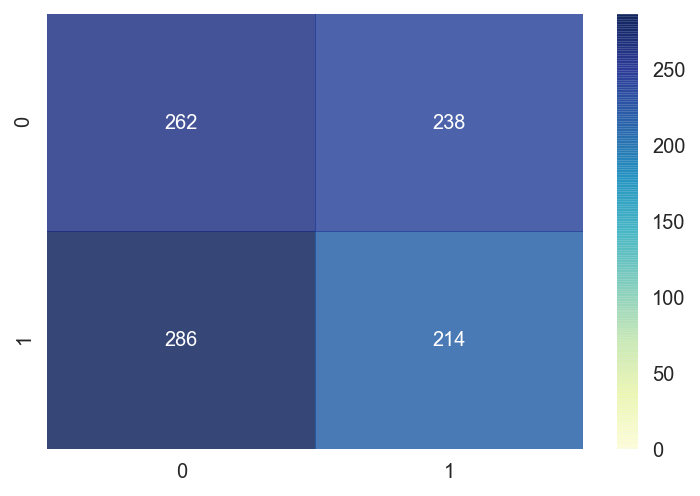

In [18]:
y_pred = model.predict_classes(X, verbose=0)
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)

# Training a Deep Neural Network

## Complex Data - Moons

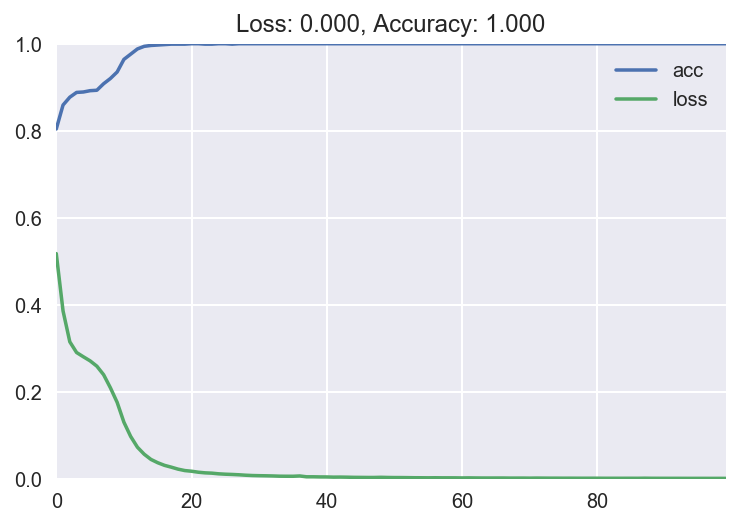

In [19]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=0)

model = Sequential()
model.add(Dense(4, input_shape=(2,), activation='tanh'))
model.add(Dense(2, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=100)

plot_loss_accuracy(history)

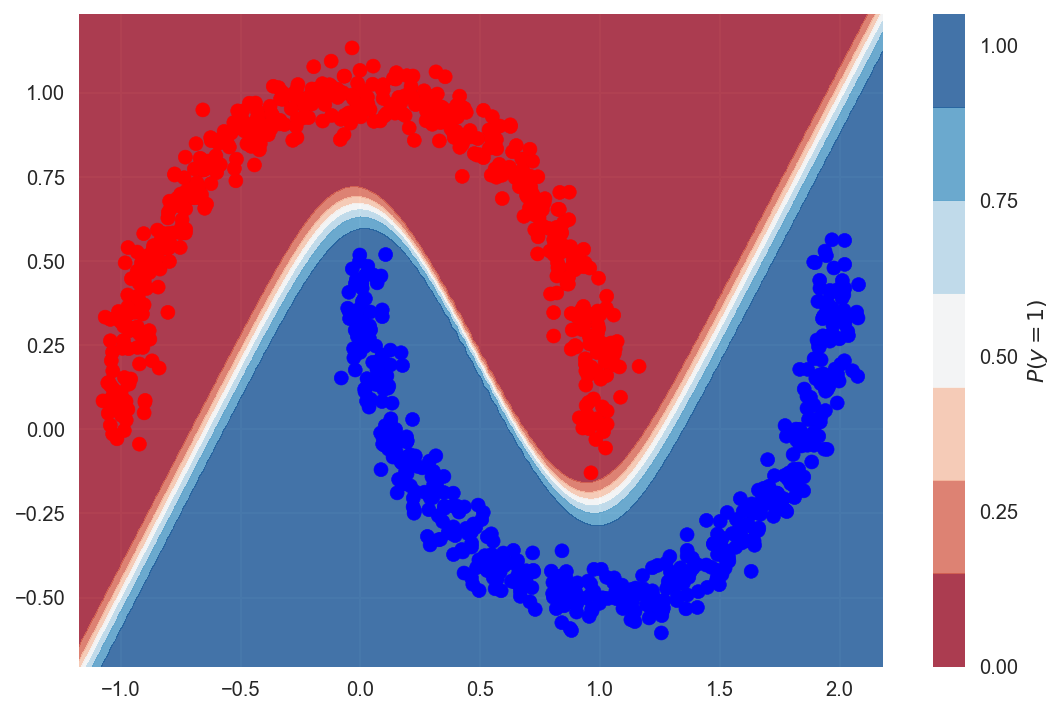

In [20]:
plot_decision_boundary(lambda x: model.predict(x), X, y)

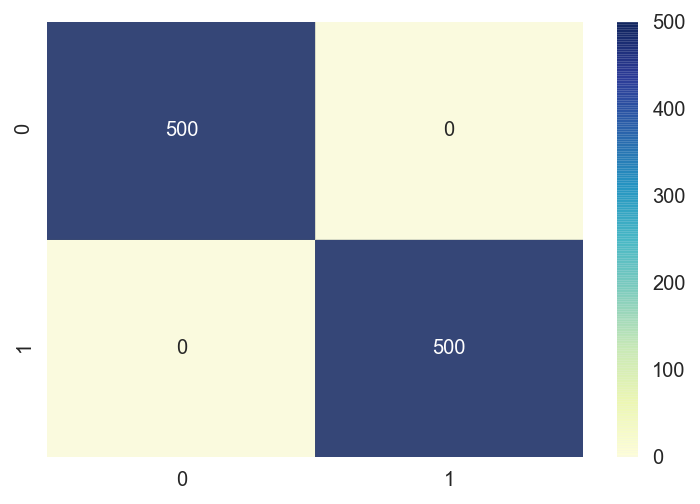

In [21]:
plot_confusion_matrix(model, X, y)

## Complex Data - Circles

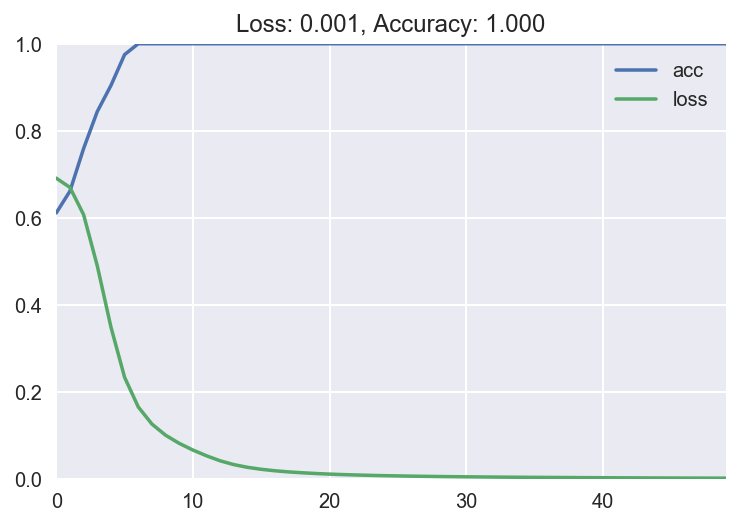

In [22]:
X, y = make_circles(n_samples=1000, noise=0.05, factor=0.3, random_state=0)

model = Sequential()
model.add(Dense(4, input_shape=(2,), activation='tanh'))
model.add(Dense(2, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=50)

plot_loss_accuracy(history)

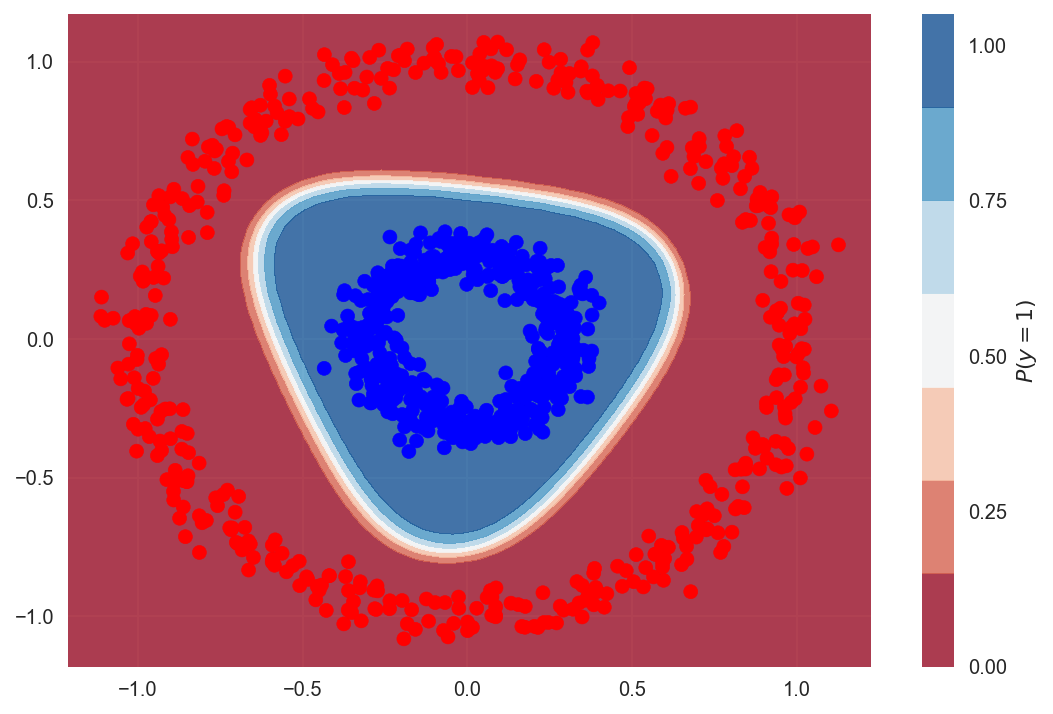

In [23]:
plot_decision_boundary(lambda x: model.predict(x), X, y)

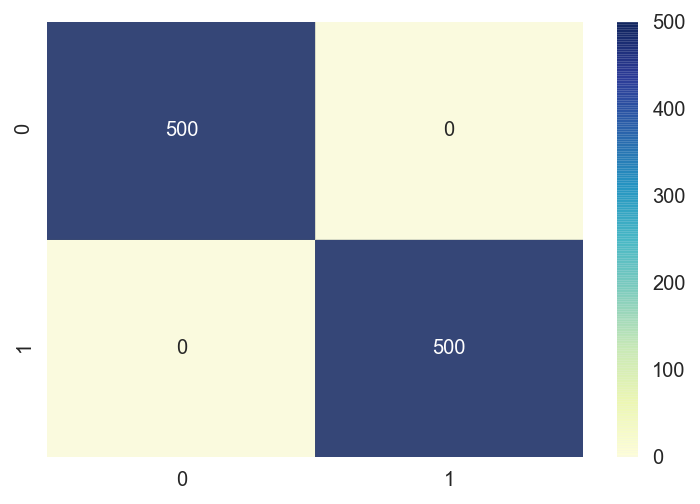

In [24]:
plot_confusion_matrix(model, X, y)

## Complex Data - Sine Wave

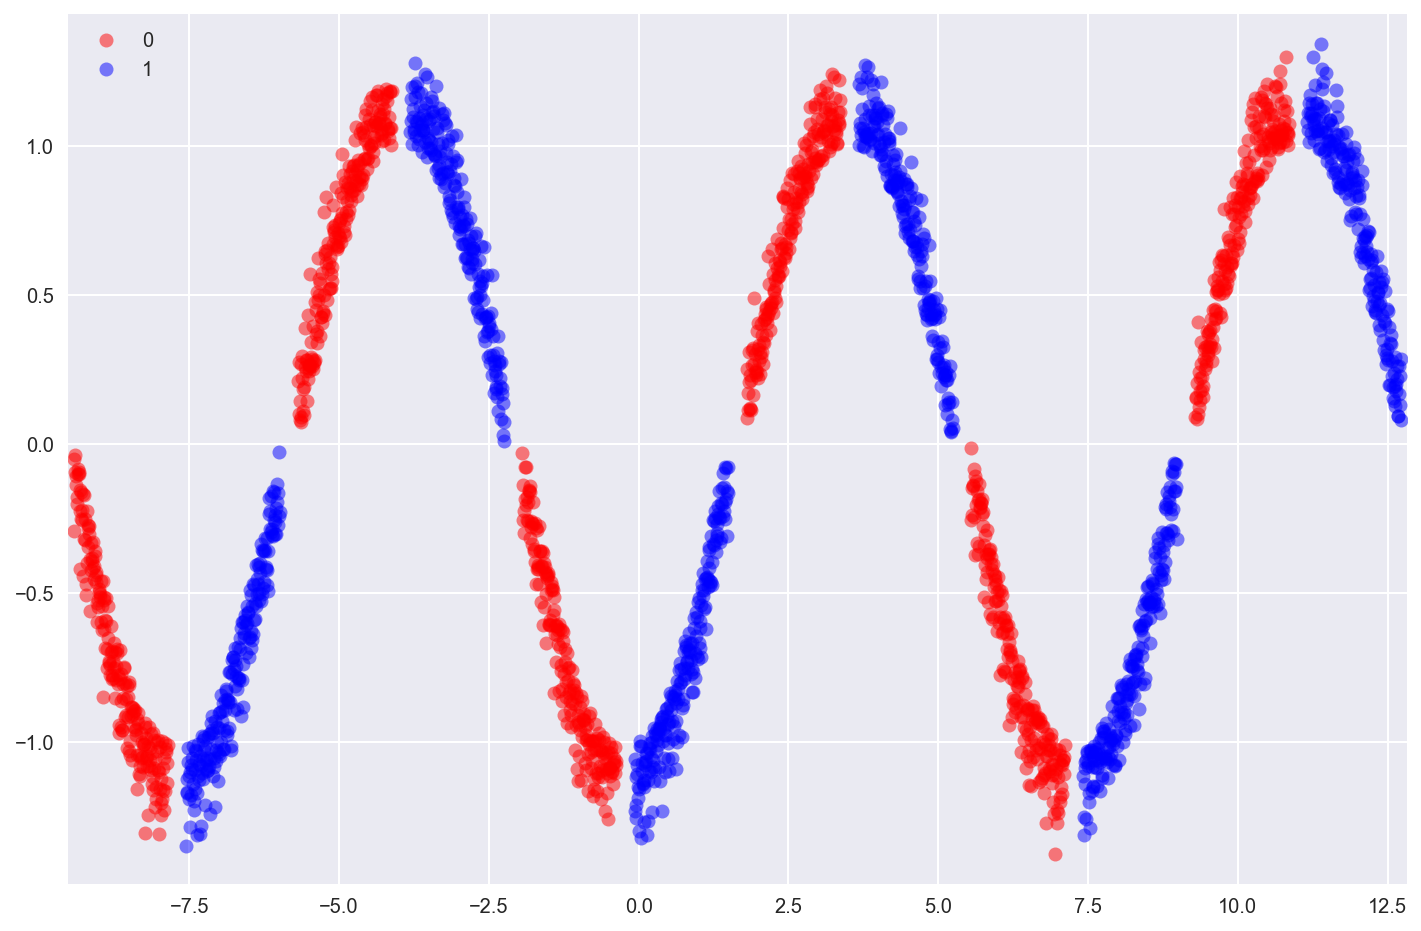

In [31]:
c = 3
num = 2400
step = num/(c*4)
# np.random.seed(0)
x0 = np.linspace(-c*np.pi, c*np.pi, num)
x1 = np.sin(x0)
noise = np.random.normal(0, 0.1, num) + 0.1
noise = np.sign(x1) * np.abs(noise)
x1  = x1 + noise
x0 = x0 + (np.asarray(range(num)) / step) * 0.3
X = np.column_stack((x0, x1))
y = np.asarray([int((i/step)%2==1) for i in range(len(x0))])

plt.figure(figsize=(12, 8))
plot_data(X, y)

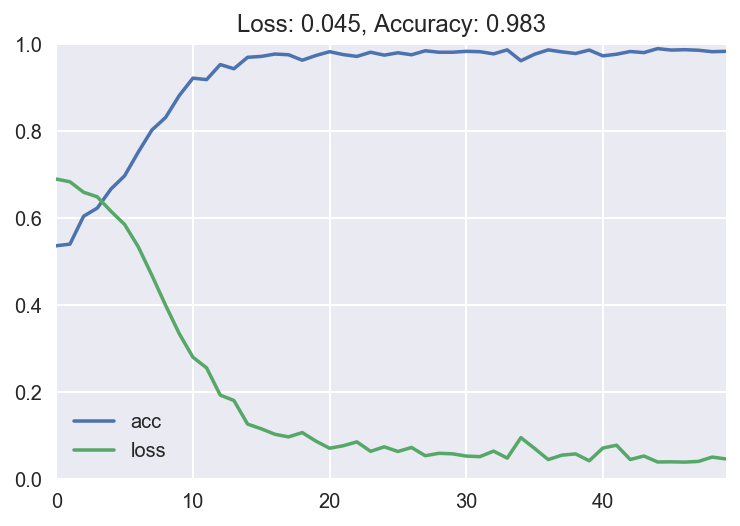

In [32]:
model = Sequential()
model.add(Dense(64, input_shape=(2,), activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=50)

plot_loss_accuracy(history)

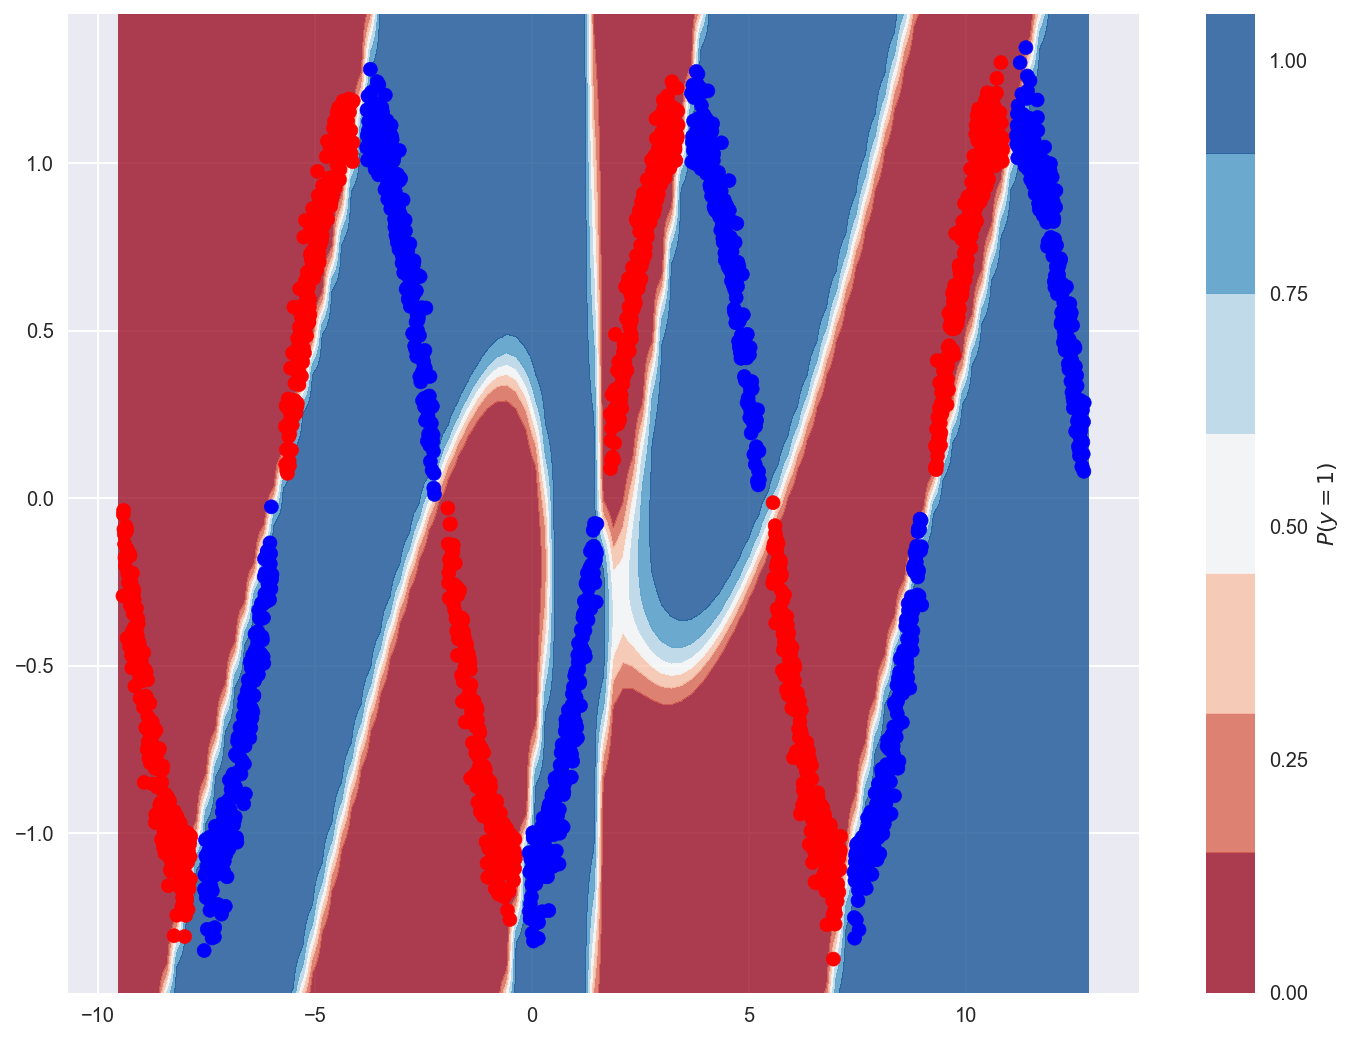

In [33]:
plot_decision_boundary(lambda x: model.predict(x), X, y, figsize=(12, 9))

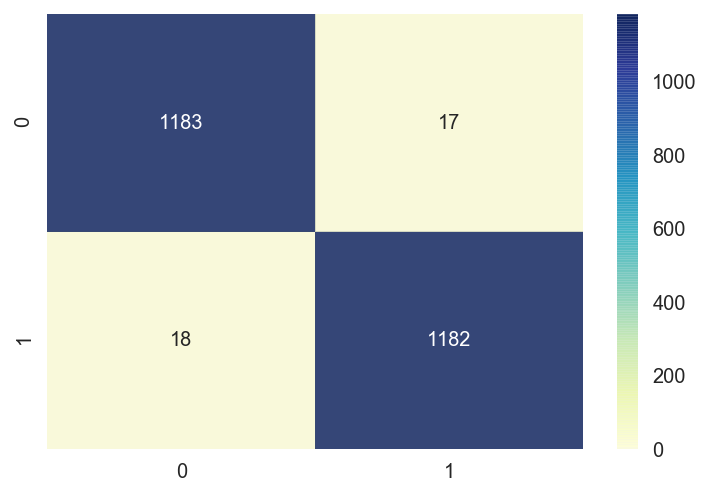

In [34]:
plot_confusion_matrix(model, X, y)

# Case Study - Binary Classification

## Data Visualization & Preparation

In [35]:
rawdf = pd.read_csv('../data/HR.csv')
rawdf.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [36]:
rawdf.rename(columns={'average_montly_hours': 'average_monthly_hours'}, inplace=True)
rawdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_monthly_hours    14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [37]:
rawdf.describe()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,"14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00"
mean,0.61,0.72,3.80,201.05,3.50,0.14,0.24,0.02
std,0.25,0.17,1.23,49.94,1.46,0.35,0.43,0.14
min,0.09,0.36,2.00,96.00,2.00,0.00,0.00,0.00
25%,0.44,0.56,3.00,156.00,3.00,0.00,0.00,0.00
50%,0.64,0.72,4.00,200.00,3.00,0.00,0.00,0.00
75%,0.82,0.87,5.00,245.00,4.00,0.00,0.00,0.00
max,1.00,1.00,7.00,310.00,10.00,1.00,1.00,1.00


In [38]:
(rawdf['left'].value_counts())/rawdf['left'].count()

0   0.76
1   0.24
Name: left, dtype: float64

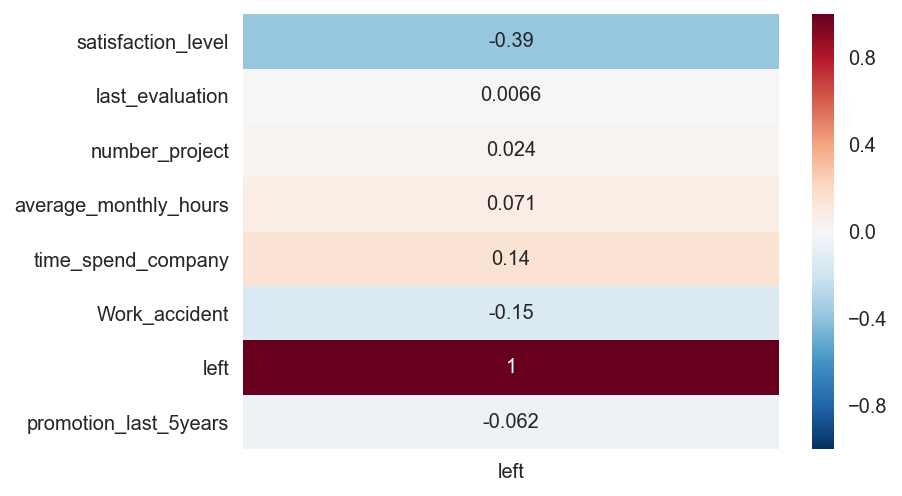

In [39]:
sns.heatmap(rawdf.corr()[['left']], annot=True, vmin=-1, vmax=1)

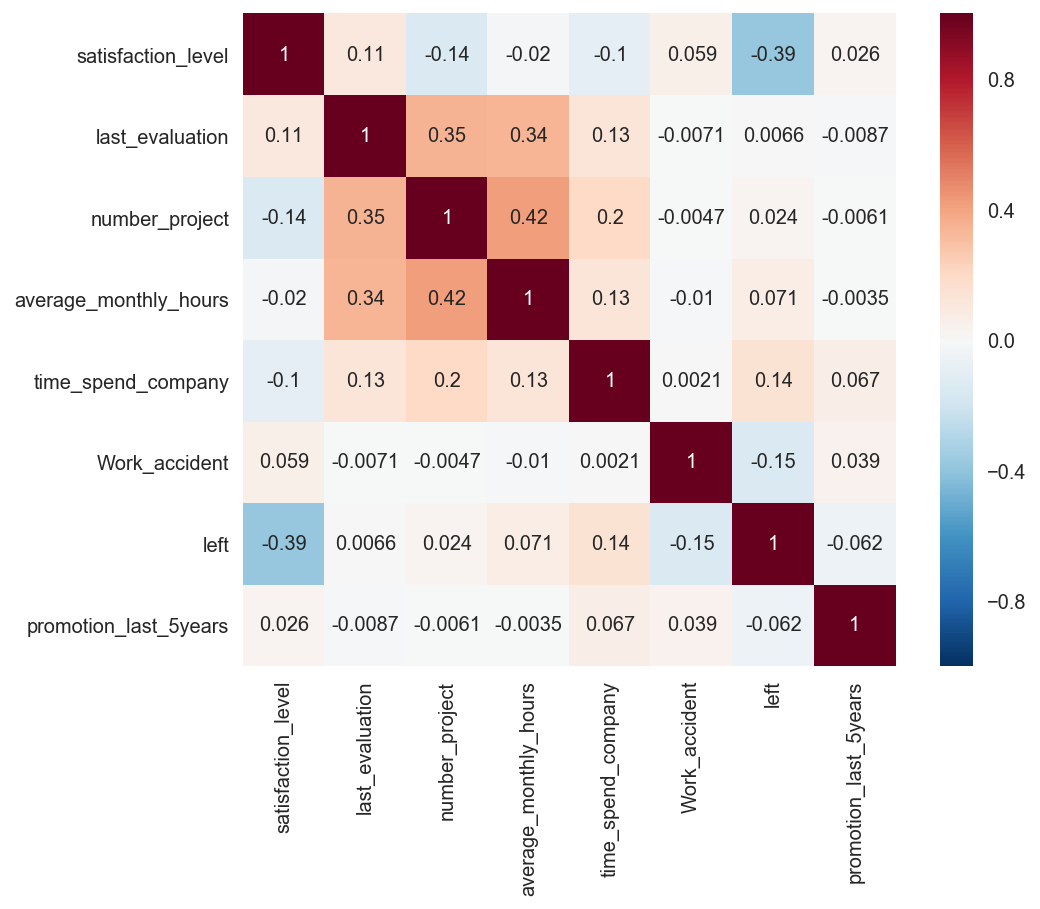

In [40]:
plt.figure(figsize=(8, 6))
sns.heatmap(rawdf.corr(), annot = True, square=True, vmin=-1, vmax=1)

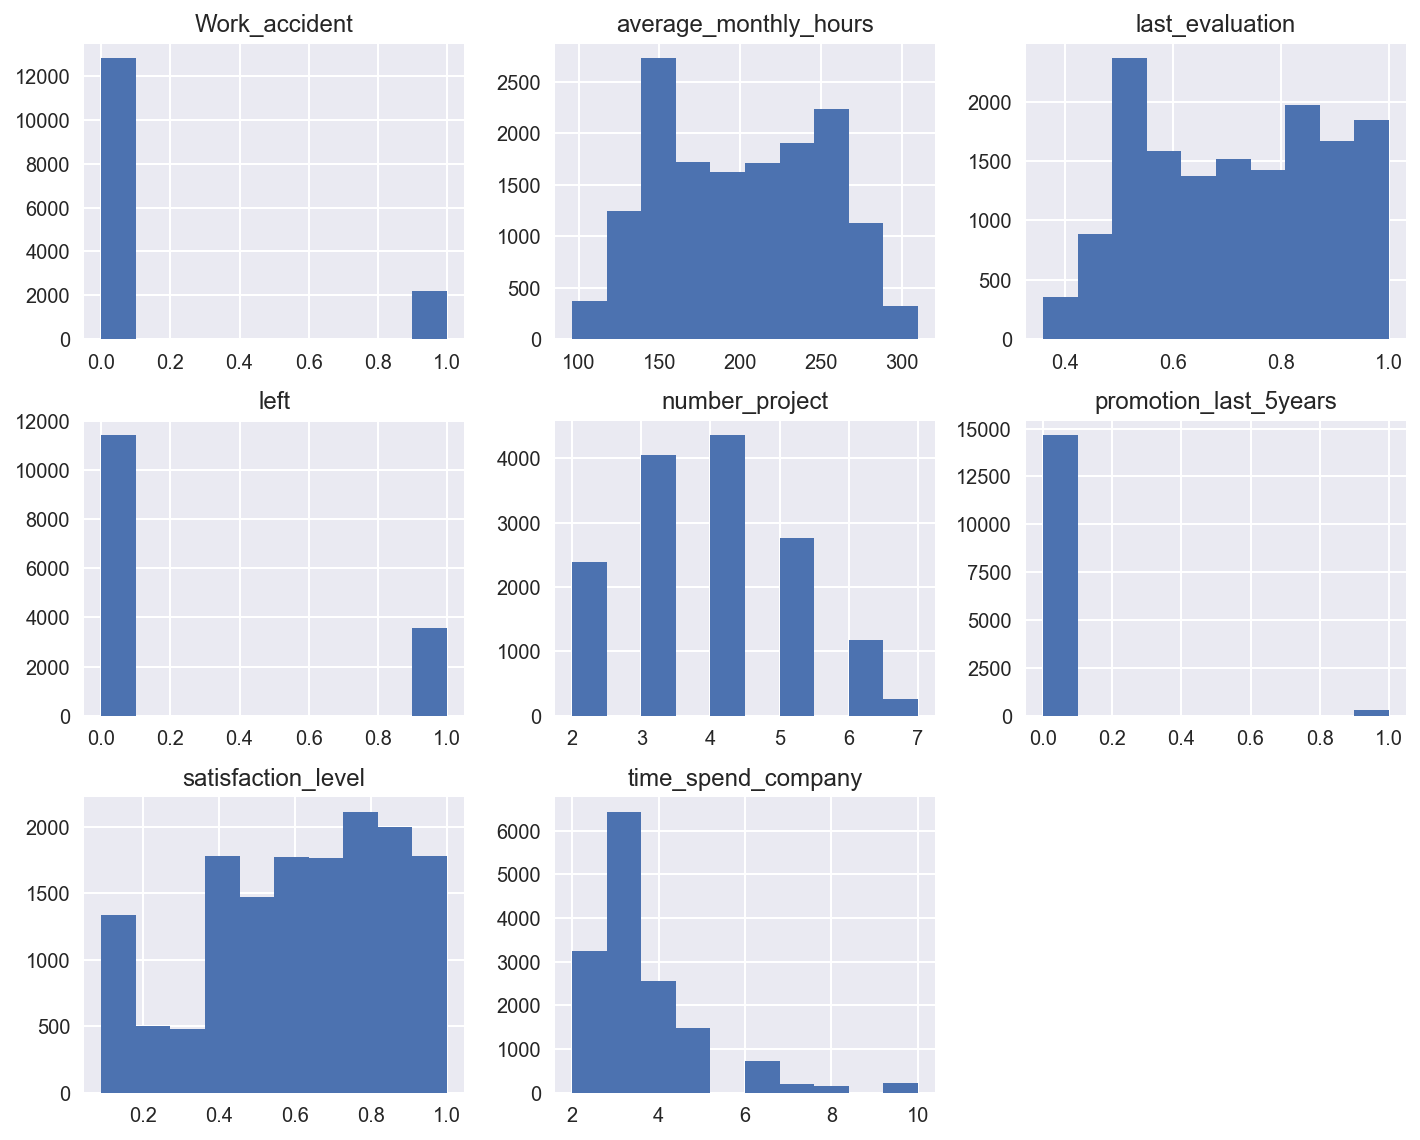

In [41]:
rawdf.hist(figsize=(10, 8))
plt.tight_layout()

In [42]:
df = rawdf.copy()

ss = StandardScaler()
scale_features = ['average_monthly_hours', 'number_project', 'time_spend_company']
df[scale_features] = ss.fit_transform(df[scale_features])

categorical_features = ['sales', 'salary']
df_cat = pd.get_dummies(df[categorical_features])
df = df.drop(categorical_features, axis=1)
df = pd.concat([df, df_cat], axis=1)
df.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales_IT,sales_RandD,...,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,-1.46,-0.88,-0.34,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,0.97,1.22,1.71,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,2.59,1.42,0.34,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,0.97,0.44,1.03,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,-1.46,-0.84,-0.34,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [43]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales_IT,sales_RandD,...,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,salary_high,salary_low,salary_medium
count,"14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00",...,"14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00"
mean,0.61,0.72,0.00,-0.00,-0.00,0.14,0.24,0.02,0.08,0.05,...,0.05,0.04,0.06,0.06,0.28,0.15,0.18,0.08,0.49,0.43
std,0.25,0.17,1.00,1.00,1.00,0.35,0.43,0.14,0.27,0.22,...,0.22,0.20,0.23,0.24,0.45,0.36,0.39,0.28,0.50,0.50
min,0.09,0.36,-1.46,-2.10,-1.03,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.44,0.56,-0.65,-0.90,-0.34,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.64,0.72,0.16,-0.02,-0.34,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.82,0.87,0.97,0.88,0.34,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00
max,1.00,1.00,2.59,2.18,4.45,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [44]:
X = df.drop('left', axis=1).values
y = df['left'].values
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(14999, 20) (14999,)
(10499, 20) (10499,) (4500, 20) (4500,)


## Logistic Regression Model

Epoch 1/5
10499/10499 [==============================] - 0s - loss: 0.4690 - acc: 0.7612     
Epoch 2/5
10499/10499 [==============================] - 0s - loss: 0.4384 - acc: 0.7853     
Epoch 3/5
10499/10499 [==============================] - 0s - loss: 0.4377 - acc: 0.7837     
Epoch 4/5
10499/10499 [==============================] - 0s - loss: 0.4360 - acc: 0.7888     
Epoch 5/5
10499/10499 [==============================] - 0s - loss: 0.4375 - acc: 0.7870     


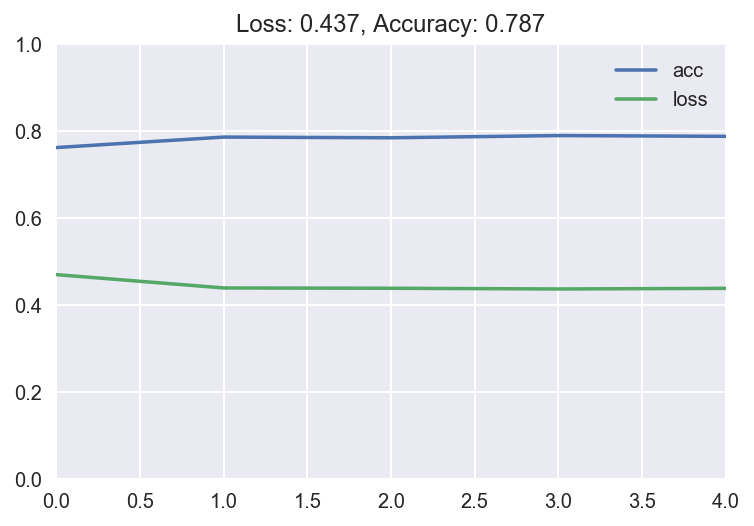

In [45]:
lr_model = Sequential()
lr_model.add(Dense(1, input_shape=(X_train.shape[1],), activation='sigmoid'))

lr_model.compile(Adam(lr=0.03), 'binary_crossentropy', metrics=['accuracy'])

lr_history = lr_model.fit(X_train, y_train, verbose=1, epochs=5)
plot_loss_accuracy(lr_history)

             precision    recall  f1-score   support

          0       0.81      0.94      0.87      3462
          1       0.57      0.28      0.37      1038

avg / total       0.76      0.78      0.76      4500



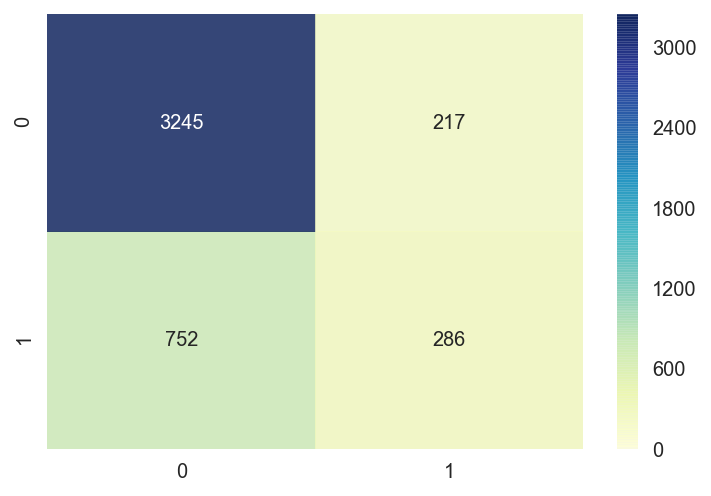

In [46]:
y_pred = lr_model.predict_classes(X_test, verbose=0)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(lr_model, X_test, y_test)

In [47]:
def get_model():
    return lr_model

model = KerasClassifier(build_fn=get_model, epochs=5, verbose=0)
scores = cross_val_score(model, X, y, cv=5)
print(scores)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores.mean(), 100*scores.std()*2))

[ 0.46466667  0.899       0.90866667  0.86233333  0.59086362]
Accuracy: 74.51% (+/- 36.51%)


## Deep Model

Epoch 1/5
10499/10499 [==============================] - 1s - loss: 0.2241 - acc: 0.9174     
Epoch 2/5
10499/10499 [==============================] - 0s - loss: 0.1509 - acc: 0.9517     
Epoch 3/5
10499/10499 [==============================] - 0s - loss: 0.1421 - acc: 0.9554     
Epoch 4/5
10499/10499 [==============================] - 0s - loss: 0.1387 - acc: 0.9573     
Epoch 5/5
10499/10499 [==============================] - 0s - loss: 0.1272 - acc: 0.9593     


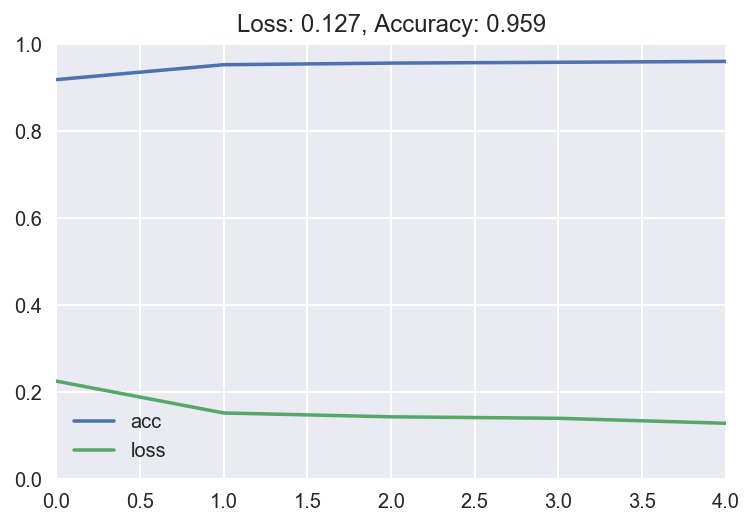

In [48]:
deep_model = Sequential()
deep_model.add(Dense(64, input_shape=(X_train.shape[1],), activation='tanh'))
deep_model.add(Dense(16, activation='tanh'))
deep_model.add(Dense(1, activation='sigmoid'))

deep_model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

deep_history = deep_model.fit(X_train, y_train, verbose=1, epochs=5)
plot_loss_accuracy(deep_history)

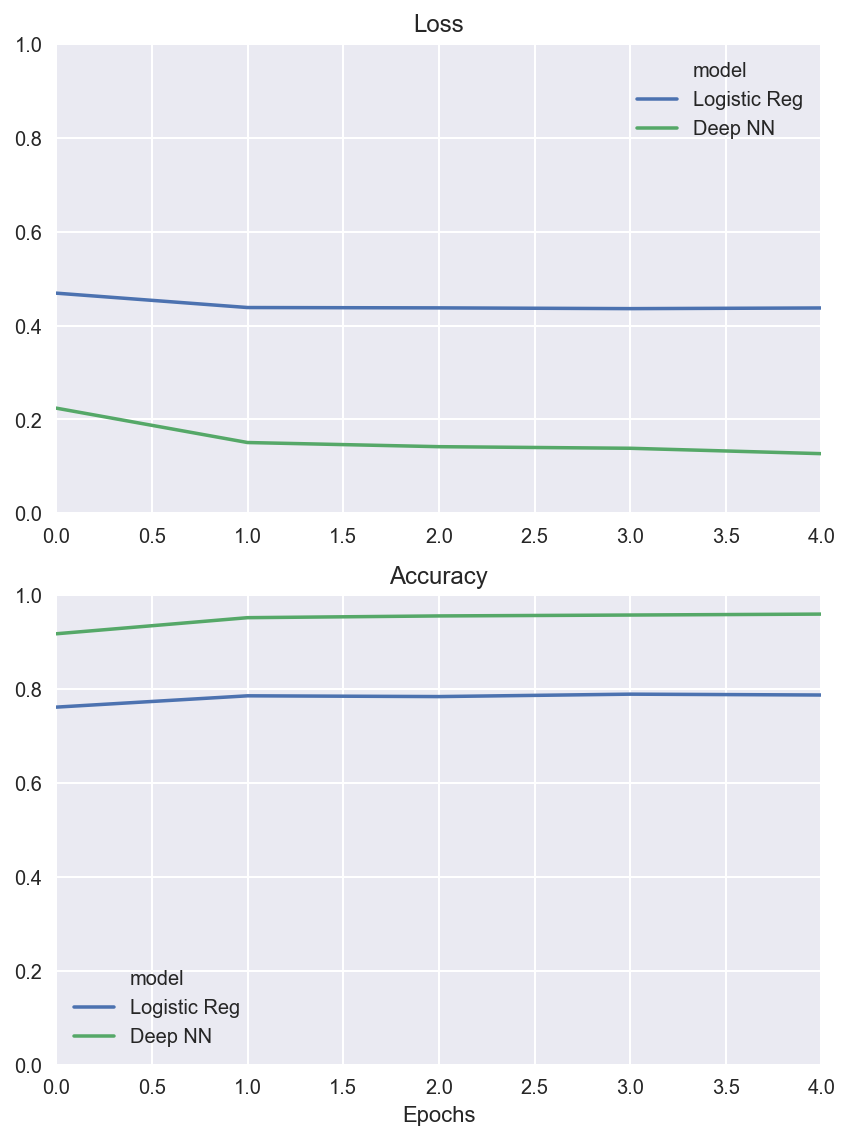

In [49]:
plot_compare_histories([lr_history, deep_history], ['Logistic Reg', 'Deep NN'])

             precision    recall  f1-score   support

          0       0.96      0.98      0.97      3462
          1       0.93      0.87      0.90      1038

avg / total       0.95      0.95      0.95      4500



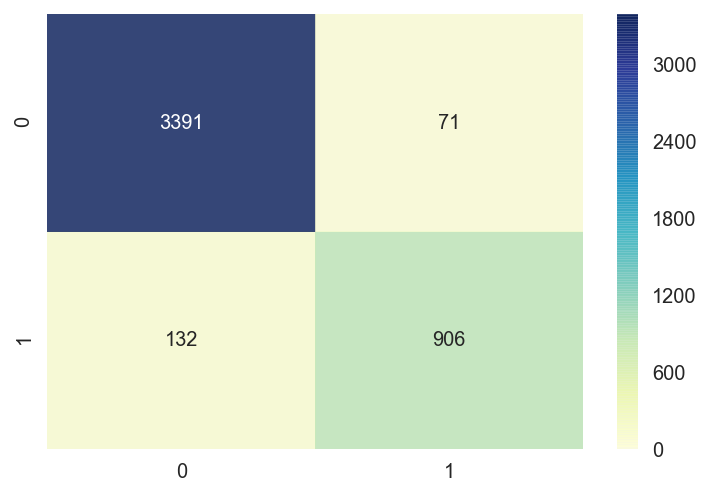

In [50]:
y_pred = deep_model.predict_classes(X_test, verbose=0)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(deep_model, X_test, y_test)

In [51]:
def get_model():
    return deep_model

model = KerasClassifier(build_fn=get_model, epochs=5, verbose=0)
scores = cross_val_score(model, X, y, cv=5)
print(scores)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores.mean(), 100*scores.std()*2))

[ 0.91233333  0.977       0.96066667  0.987       0.95598533]
Accuracy: 95.86% (+/- 5.14%)


In [52]:
deep_model_vis = Sequential()
deep_model_vis.add(Dense(64, input_shape=(X_train.shape[1],), activation='tanh'))
deep_model_vis.add(Dense(16, activation='tanh'))
deep_model_vis.add(Dense(2, activation='tanh'))
deep_model_vis.add(Dense(1, activation='sigmoid'))

deep_model_vis.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

deep_model_vis.fit(X_train, y_train, verbose=0, epochs=10)

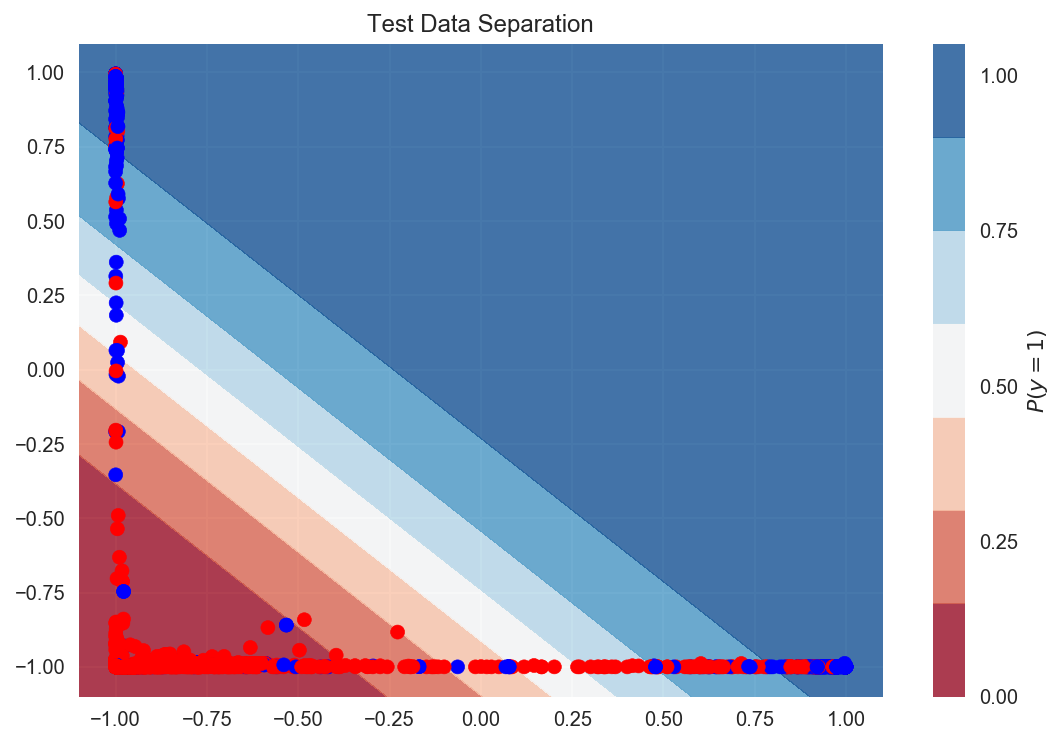

In [53]:
inp = deep_model_vis.layers[0].input
out = deep_model_vis.layers[2].output

# input to 2-D
func = K.function([inp], [out])

# 2-D to score
func2 = K.function([deep_model_vis.layers[3].input], [deep_model_vis.layers[3].output])

features = func([X_test])[0]
plot_decision_boundary(lambda x: func2([x])[0], features, y_test)
plt.title('Test Data Separation')

# Case Study - MultiClass Classification

In [54]:
df = pd.read_csv('../data/iris.csv')
df.head()

,sepal_length,sepal_width,petal_length,petal_width,label
0,5.10,3.50,1.40,0.20,setosa
1,4.90,3.00,1.40,0.20,setosa
2,4.70,3.20,1.30,0.20,setosa
3,4.60,3.10,1.50,0.20,setosa
4,5.00,3.60,1.40,0.20,setosa


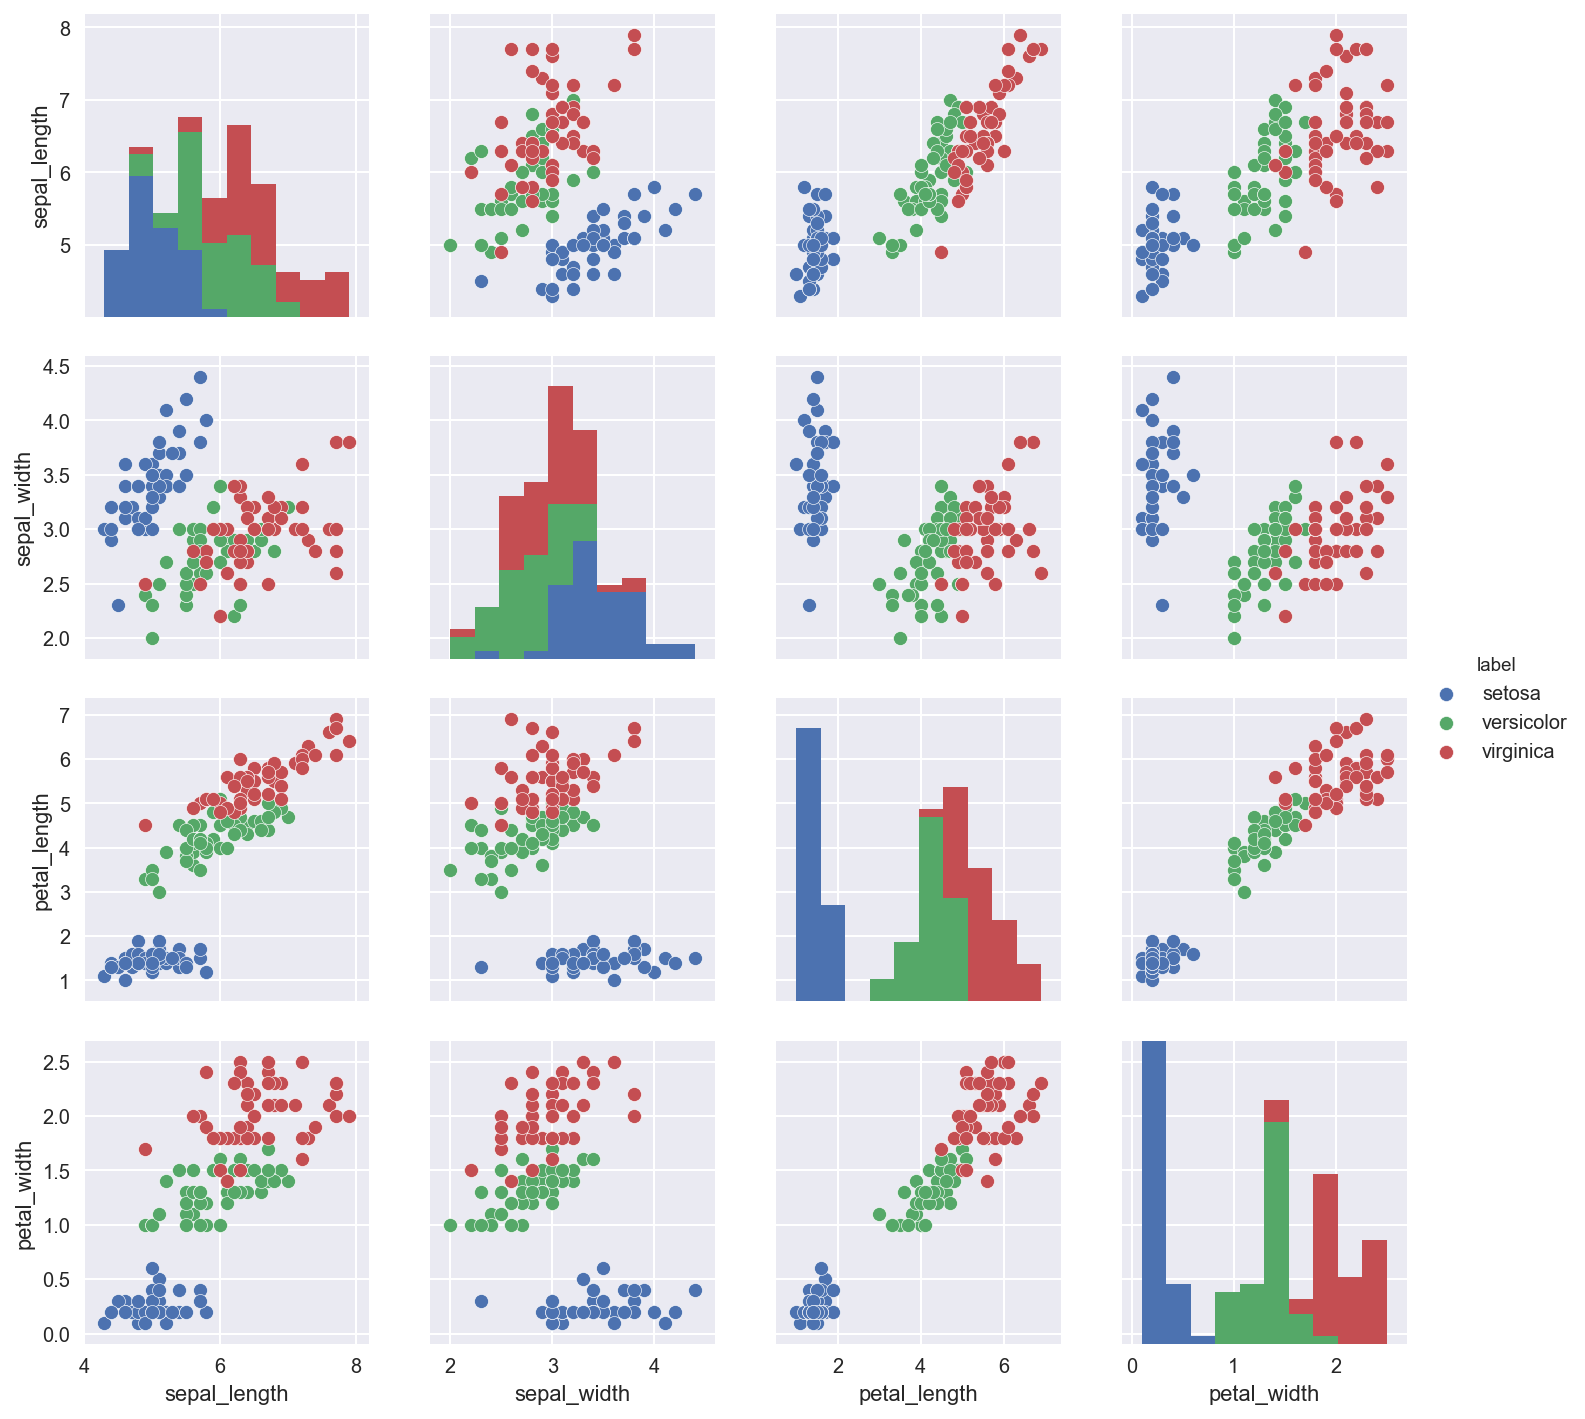

In [55]:
sns.pairplot(df, hue='label')

In [56]:
X = df.values[:, :-1]
y = pd.get_dummies(df['label']).values
print(X.shape, y.shape)

(150, 4) (150, 3)


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape)

(120, 4) (120, 3)


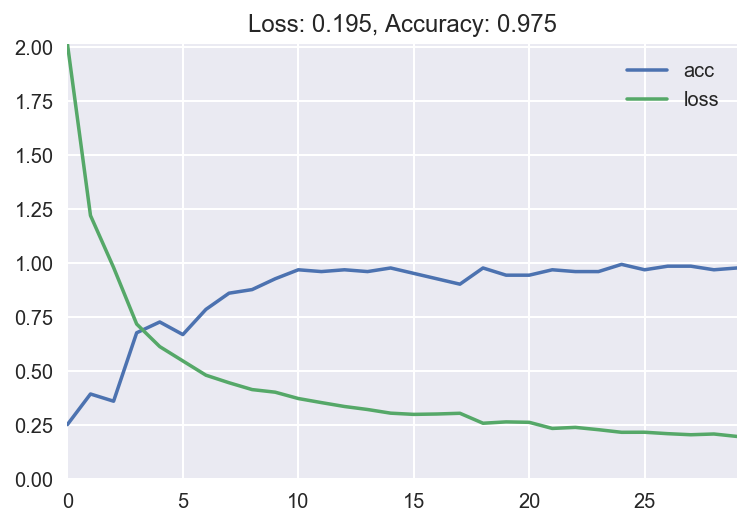

In [58]:
model = Sequential()
model.add(Dense(3, input_shape=(X.shape[1],), activation='softmax'))

model.compile(Adam(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, verbose=0)
plot_loss_accuracy(history)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         9
          1       0.89      0.89      0.89         9
          2       0.92      0.92      0.92        12

avg / total       0.93      0.93      0.93        30



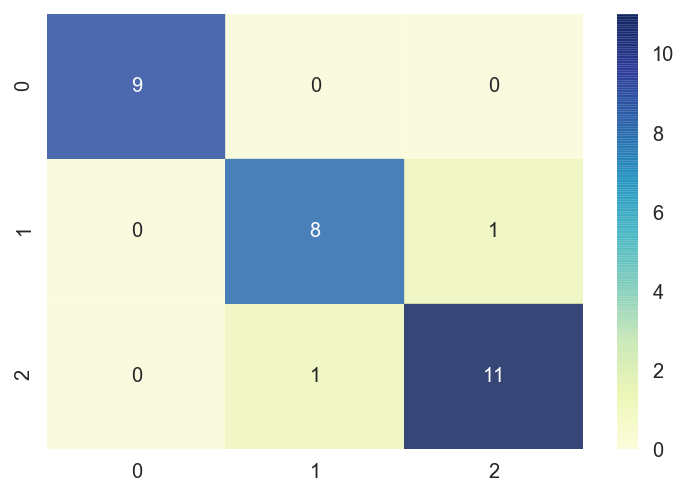

In [59]:
y_pred_class = model.predict_classes(X_test, verbose=0)
y_test_class = np.argmax(y_test, axis=1)
print(classification_report(y_test_class, y_pred_class))
plot_confusion_matrix(model, X_test, y_test_class)